In [1]:
#---import libraries relating to data manipulation, visualization---------------------------------------------------
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option("max_colwidth", None)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import json

#-------import libraries to evaluate the deep learning model---------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, multilabel_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

#------ import Deep Learning Libraries-------#

import torch
import torch.nn as nn
import torch.optim as optim
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import pickle

import sys
sys.path.append('../../src')  # Add the 'src' directory to the path

#### Import Data Loading and Processing Functions
from multimodal.helper_functions import  reproducible_comp, get_final_df

#### Import Model Architecture
from multimodal.model_architecture import Generic1DCNN
reproducible_comp()

2023-11-06 11:28:44.748946: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-06 11:28:44.748997: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-06 11:28:44.749021: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-06 11:28:44.755863: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-06 11:28:45.526575: W tensorflow/compiler/

In [2]:
file_path = "../../data/processed_data/force_inner.pkl"
with open(file_path, 'rb') as picklefile:
    data = pickle.load(picklefile)

features_force_inner, category_force_inner, category_names, df_force_inner = get_final_df(data, is_acc_data=0, is_multilabel=1)

In [3]:
labels = category_force_inner.copy()
features=features_force_inner.copy()
print("Features Shape: ", features.shape)
print("Labels Shape: ", labels.shape)

Features Shape:  (1350, 1)
Labels Shape:  (1350, 4)


In [4]:
max_length = 150
for i in range (len(features)):
    if(len(features[i][0]<max_length)):
        features[i][0]=np.pad(features[i][0], (0,max_length-len(features[i][0])), 'constant', constant_values=(0))
feat= np.zeros(len(features) *max_length).reshape(-1, max_length)
for i in range(len(features)):
    feat[i]= np.concatenate((features[i][0]), axis=None)
    

print("Updated Features Shape: ", feat.shape)

Updated Features Shape:  (1350, 150)


# Loading Best Configs

In [5]:
# Specify the path where you want to save the JSON file
config_file_path = "../../02_Optuna_Runs/force/best_configs/force_inner_best_configs.json"

# Load the saved configuration
with open(config_file_path, "r") as config_file:
    best_configs = json.load(config_file)

best_params = best_configs["best_params"]
print(best_params)

{'lr': 0.006170767628576648, 'dropout_prob': 0.03377115813672493, 'hidden_channels': 73, 'n_layers': 4, 'kernel_size': 7, 'stride': 2, 'padding': 4, 'pooling_type': 'max', 'use_batch_norm': True}


In [6]:
X_train = feat.reshape(-1, 1, feat.shape[1])
y_train = labels.copy()

print(X_train.shape)
print(y_train.shape)

(1350, 1, 150)
(1350, 4)


In [39]:
# Define the start, end, and interval
start = 0.95
end = 0.04
interval = -0.01

validation_sizes = [round(start + i * interval, 2) for i in range(int((end - start) / interval) + 1)]

In [47]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score

def multi_label_accuracy(y_true, y_pred):
    # Check if each label is correctly predicted
    label_accuracies = np.mean(y_true == y_pred, axis=0)
    # Compute the overall accuracy by taking the mean of label accuracies
    accuracy = np.mean(label_accuracies)
    return accuracy

# Convert your data to PyTorch tensors
x_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

input_channels = 1
num_classes = 4
n_layers = best_params["n_layers"]
kernel_size = best_params["kernel_size"]
stride = best_params["stride"]
padding = best_params["padding"]
hidden_channels = best_params["hidden_channels"]
dropout_prob = best_params["dropout_prob"]
pooling_type = best_params["pooling_type"]
use_batch_norm = best_params["use_batch_norm"]

# Define your loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Lists to store training and validation loss values and results for different training sizes
results = []

num_epochs = 50

for validation_size in validation_sizes:
    try:
        print(f"Training Size: {int((1-validation_size) * 100)}%")
        train_losses_iter = []  # Store training losses for this training size
        valid_losses_iter = []  # Store validation losses for this training size

        # Split the data into training and validation sets for this training size
        # Split the data into training and validation sets
        x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(
            x_train, y_train, test_size=validation_size, random_state=42
        )

        train_dataset = TensorDataset(x_train_split, y_train_split)
        valid_dataset = TensorDataset(x_valid_split, y_valid_split)

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

        model = Generic1DCNN(input_channels, num_classes, n_layers, kernel_size, stride, padding,
                             hidden_channels, dropout_prob, pooling_type, use_batch_norm).to(device)

        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])

        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels.float())
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            train_losses_iter.append(running_loss / len(train_loader))

            # Validation loss calculation (similar to training loop)
            model.eval()
            valid_loss = 0.0
            with torch.no_grad():
                for inputs_valid, labels_valid in valid_loader:
                    inputs_valid, labels_valid = inputs_valid.to(device), labels_valid.to(device)
                    outputs_valid = model(inputs_valid)
                    loss_valid = criterion(outputs_valid, labels_valid.float())
                    valid_loss += loss_valid.item()

            valid_losses_iter.append(valid_loss / len(valid_loader))

            if (epoch + 1) % 10 == 0:
                print(f"Training Size: {int((1-validation_size) * 100)}%, Epoch {epoch + 1}/{num_epochs}, "
                      f"Training Loss: {running_loss / len(train_loader)}, Validation Loss: {valid_loss / len(valid_loader)}")

        # Evaluation on the validation set for this training size
        model.eval()
        y_true_valid = []
        y_pred_valid = []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.int()
                outputs = model(inputs)
                predicted = (outputs > 0).int()
                y_true_valid.append(labels.cpu().numpy())
                y_pred_valid.append(predicted.cpu().numpy())

        # Convert lists to NumPy arrays for calculations
        y_true_valid = np.array(y_true_valid[0]).reshape(-1, 4)
        y_pred_valid = np.array(y_pred_valid[0]).reshape(-1, 4)

        accuracy = multi_label_accuracy(y_true_valid, y_pred_valid)
        f1 = f1_score(y_true_valid, y_pred_valid, average='macro')

        results.append({
            "Training Size": int((1-validation_size) * 100),
            "Multi-label Validation Accuracy": accuracy,
            "F1 Score": f1
        })
        print(f"Accuracy: {accuracy}\n F1-Score: {f1}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

Training Size: 5%
Training Size: 5%, Epoch 10/50, Training Loss: 0.319632813334465, Validation Loss: 0.3045557794116792
Training Size: 5%, Epoch 20/50, Training Loss: 0.3192504867911339, Validation Loss: 0.10577983870392754
Training Size: 5%, Epoch 30/50, Training Loss: 0.06458928808569908, Validation Loss: 0.07036305121367886
Training Size: 5%, Epoch 40/50, Training Loss: 0.06674021414528397, Validation Loss: 0.07165100123910677
Training Size: 5%, Epoch 50/50, Training Loss: 0.0058213518059346825, Validation Loss: 0.03688375695076372
Accuracy: 0.99609375
 F1-Score: 0.9948979591836735
Training Size: 6%
Training Size: 6%, Epoch 10/50, Training Loss: 0.20630185306072235, Validation Loss: 0.2765395000576973
Training Size: 6%, Epoch 20/50, Training Loss: 0.02563240472227335, Validation Loss: 0.03976480765268207
Training Size: 6%, Epoch 30/50, Training Loss: 0.32878934778273106, Validation Loss: 0.07150895791128278
Training Size: 6%, Epoch 40/50, Training Loss: 0.01305253547616303, Validati

In [48]:

# Print the results for different training sizes
for result in results:
    print(f"Training Size: {result['Training Size']}%, "
          f"Multi-label Validation Accuracy: {result['Multi-label Validation Accuracy'] * 100:.2f}%, "
          f"F1 Score: {result['F1 Score']:.2f}")


Training Size: 5%, Multi-label Validation Accuracy: 99.61%, F1 Score: 0.99
Training Size: 6%, Multi-label Validation Accuracy: 99.61%, F1 Score: 0.99
Training Size: 6%, Multi-label Validation Accuracy: 100.00%, F1 Score: 1.00
Training Size: 7%, Multi-label Validation Accuracy: 100.00%, F1 Score: 1.00
Training Size: 8%, Multi-label Validation Accuracy: 100.00%, F1 Score: 1.00
Training Size: 9%, Multi-label Validation Accuracy: 100.00%, F1 Score: 1.00
Training Size: 10%, Multi-label Validation Accuracy: 100.00%, F1 Score: 1.00
Training Size: 12%, Multi-label Validation Accuracy: 100.00%, F1 Score: 1.00
Training Size: 13%, Multi-label Validation Accuracy: 100.00%, F1 Score: 1.00
Training Size: 14%, Multi-label Validation Accuracy: 100.00%, F1 Score: 1.00
Training Size: 15%, Multi-label Validation Accuracy: 100.00%, F1 Score: 1.00
Training Size: 16%, Multi-label Validation Accuracy: 100.00%, F1 Score: 1.00
Training Size: 17%, Multi-label Validation Accuracy: 100.00%, F1 Score: 1.00
Trainin

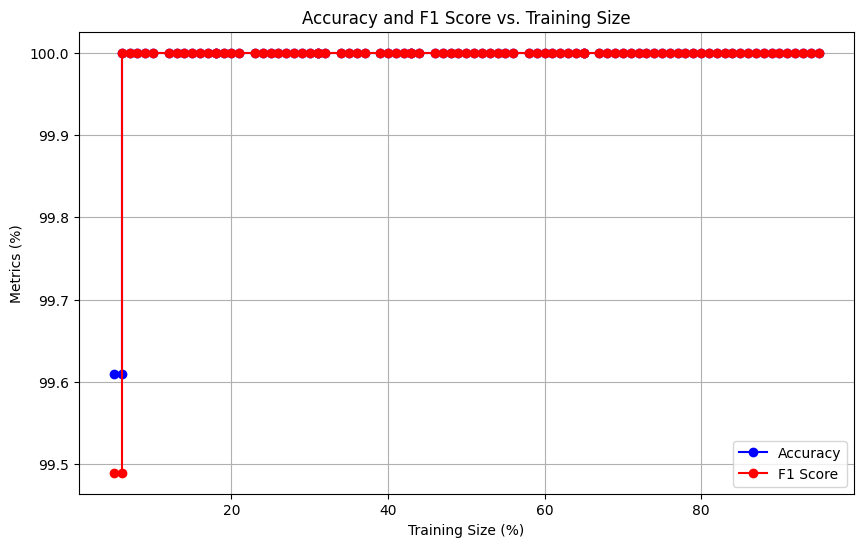

In [49]:
# Extract data for plotting
training_sizes = [result['Training Size'] for result in results]
accuracies = [result['Multi-label Validation Accuracy'] * 100 for result in results]
f1_scores = [result['F1 Score'] *100 for result in results]

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, accuracies, label='Accuracy', marker='o', linestyle='-', color='b')
plt.plot(training_sizes, f1_scores, label='F1 Score', marker='o', linestyle='-', color='r')

# Set axis labels and legend
plt.xlabel('Training Size (%)')
plt.ylabel('Metrics (%)')
plt.title('Accuracy and F1 Score vs. Training Size')
plt.legend()

# Show the plot
plt.grid()
plt.show()


# Thank You